**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Deep Learning**

**Segundo Semestre 2024**

**Profesor: Dr. Luis-Alexander Calvo-Valverde**

---

**Trabajo Práctico:** 3

**Datos de la entrega:** Jueves 7 de noviembre 2024, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo comprimido con todos los archivos de su solución a este Trabajo Práctico. En caso de requerir mucho espacio, solicitarle al profesor una carpeta en One-Drive para subir la solución.

---

**Estudiantes:**
- Andrey Arguedas Espinoza - 2020426569

# Entregable 1.  Experimentación con Series Temporales

1. El objetivo central es investigar y experimentar en el uso de Deep Learning para la tarea de predicción en secuencias. En particular en series temporales.
1. Se adjunta el dataset, pero puede descargarlo y obtener información de él en: (https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set/data)  u otro de su elección. Sobre todo considerando la capacidad de procesamiento de que disponga.
1. Usted debe proponer e implementar el Diseño Experimental, el cual debe considerar al menos tres arquitecturas: dos existentes y una tercer arquitectura propuesta por Usted, no es problema que sea alguna de las dos primeras con algún cambio propuesto por Usted. Es requisito que se programen las capas requeridas para la red neuronal artificial, no usar frameworks que con la llamada a una función retornen el resultado.
1. Es válido utilizar código de alguna fuente como base, pero debe ser citada claramente la fuente.


## • Prerequisites

### - This version is implemented in Anaconda Navigator, if you want to to run it on Google Colab make sure to have the Pro version and mount the instance
### - Add the dataset to the same path you have the notebook so it loads inmediately

## • Import required libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## • Load the Dataset

In [5]:
# Load dataset from a .txt file
dataset = pd.read_csv('household_power_consumption.txt', delimiter=';', low_memory=False, na_values=['nan','?'])

print(dataset.head())  # Show the first few rows of the dataset
print(dataset.info())

         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total

### • Do a data transformation for the date and time fields since they can be handled as one, will be easier in the future to handle it this way

In [6]:
# Combine 'Date' and 'Time' columns into a single datetime column
dataset['dt'] = pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'], dayfirst=True, errors='coerce')

# Set the combined 'dt' column as the index
dataset.set_index('dt', inplace=True)

# Drop the original 'Date' and 'Time' columns if no longer needed
dataset.drop(columns=['Date', 'Time'], inplace=True)

# Preview the first few rows
print(dataset.head())
print(dataset.info())

                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

### • Dataset cleaning: This dataset contains certain registers with invalid or missing values (nearly 1,25% of the rows), we will have to adress this by replace them with mean values of the columns

### After that we will have a dataset that will not give us problems of missing data that can affect the time series.

In [13]:
print("*** Missing values on the dataset *** ")
print(dataset.isnull().sum())

#Adressing the issue
for j in range(0, dataset.shape[1]):
    dataset.iloc[:,j] = dataset.iloc[:,j].fillna(dataset.iloc[:,j].mean())


print("*** After cleaning the dataset ***")
print(dataset.isnull().sum())

*** Missing values on the dataset *** 
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
*** After cleaning the dataset ***
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


### • With a more robust dataset, we can describe completely every column, important to notice we do not have NaN values anymore

In [14]:
# verifying a complete description of the dataframe for all columns
dataset.describe(include='all')

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


### • Now we can start to plot the factors that are of our interest.

### First we plot the Global Active Power across time

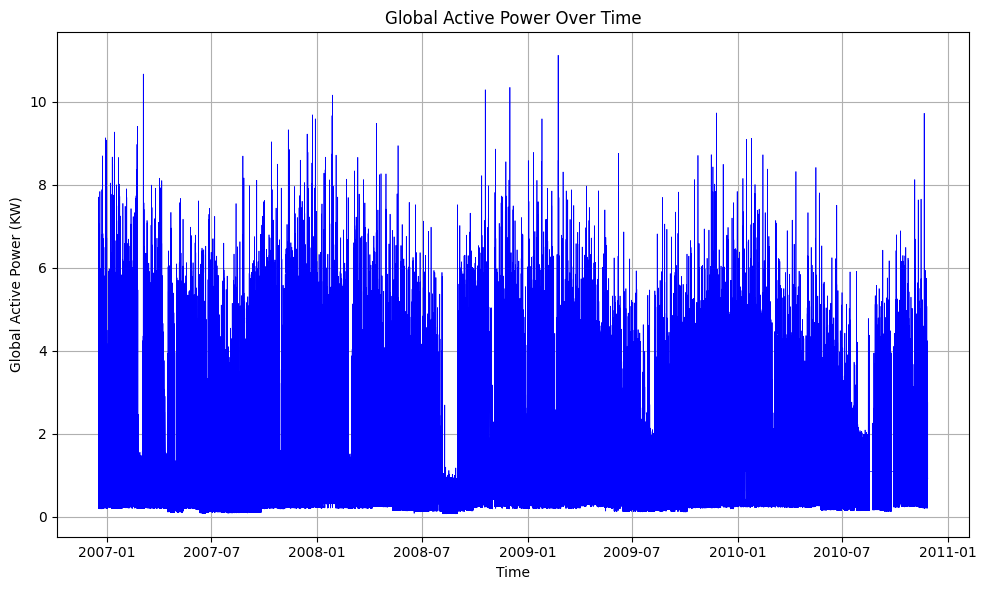

In [18]:
# ploting a graph of global active power consuption trought time
plt.figure(figsize=(10, 6))
plt.plot(dataset['Global_active_power'], label='Global Active Power (kW)', color='blue', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Global Active Power (KW)')
plt.title('Global Active Power Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

### • Now we plot the Global Reactive Power across time

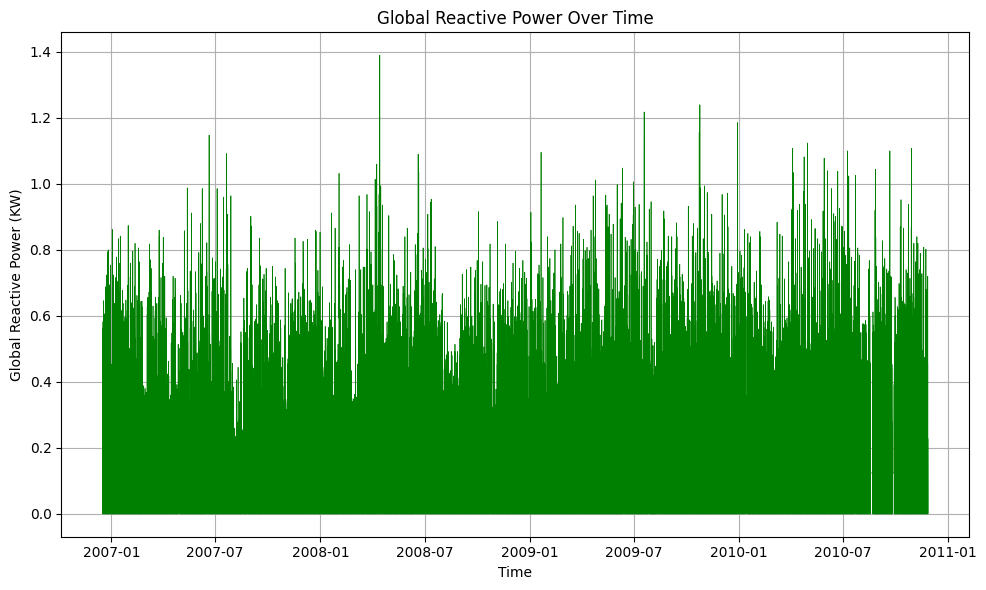

In [19]:
# ploting a graph of global active power consuption trought time
plt.figure(figsize=(10, 6))
plt.plot(dataset['Global_reactive_power'], label='Global Reactive Power (kW)', color='green', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Global Reactive Power (KW)')
plt.title('Global Reactive Power Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()